In [96]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn as sns

In [97]:
def show_heatmaps(matrix):
    matrix = matrix[0,0]
    plt.figure(figsize=(8, 6)) 
    sns.heatmap(matrix,cmap="viridis")
    plt.title("Attention")
    plt.xlabel("Key")
    plt.ylabel("Query")
    plt.show()


In [98]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super().__init__()
        # vocab 表示词汇表的大小，d_model 表示嵌入向量的维度
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model
    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

In [99]:
class PositionalEncoding(nn.Module):
    
    # 词嵌入维度 dropout概率 最大序列长度
    def __init__(self, d_model, dropout, max_len = 5000):
        super(PositionalEncoding, self).__init__()
        
        # 对于序列的每个位置 初始化每一维
        position_encoding = torch.zeros( max_len, d_model )
        
        # div_term : pos * exp( - (2i/d_model)ln1e4 ) 
            # 0~2i,2i+1~d_model-1
            # -torch.arange(0, d_model, 2) / d_model   -> -2i/d_model
        div_term = torch.exp( -torch.arange(0, d_model, 2) / d_model * math.log(10000.0) ) 
        position = torch.arange( max_len ).unsqueeze(1) # ->  [ [0], [1], [2], ... ]
        
        # position*div_term 广播机制 
        # position : (max_len, 1) div_term : (1, d_model/2)
        # -> (max_len, d_model/2)
        half_pe = position*div_term
        position_encoding[:, 0::2] = torch.sin(half_pe) # 每个token的偶数维度
        position_encoding[:, 1::2] = torch.cos(half_pe) # 每个token的奇数维度
        
        # -> (1, max_len, d_model) 方便批量操作
        position_encoding = position_encoding.unsqueeze(0)
        
        # 定义一组参数self.position_encoding 
        # 模型训练时不会更新 即调用 optimizer.step() 后该组参数不会变化，只可人为地改变它们的值
        # 但是保存模型时，该组参数又作为模型参数不可或缺的一部分被保存
        self.register_buffer('position_encoding', position_encoding)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        # x: (batch_size, position , dim)
        # 返回所有x.size(1)表示x的序列长度（可能含有pad）
        # 广播机制：每个batch都进行同样操作
        return self.dropout( x + self.position_encoding[:, : x.size(1) ] )
    
plt.figure(figsize=(15, 5))

pe = PositionalEncoding(4, 0.1, 10)
y = pe((torch.zeros(1, 10, 4)))
# print(y.shape)

# plt.plot(np.arange(1000), y[0, :, 3:7].data.numpy())
# plt.legend(["dim %d"%p for p in [3,4,5,6]])

y

tensor([[[ 0.0000,  1.1111,  0.0000,  1.1111],
         [ 0.9350,  0.6003,  0.0111,  1.1111],
         [ 1.0103, -0.4624,  0.0222,  1.1109],
         [ 0.1568, -1.1000,  0.0333,  1.1106],
         [-0.8409, -0.7263,  0.0444,  1.1102],
         [-1.0655,  0.3152,  0.0555,  0.0000],
         [-0.3105,  1.0669,  0.0666,  1.1091],
         [ 0.7300,  0.8377,  0.0777,  1.1084],
         [ 1.0993, -0.1617,  0.0888,  1.1076],
         [ 0.4579, -1.0124,  0.0999,  0.0000]]])

<Figure size 1500x500 with 0 Axes>

In [100]:
# def attention(query, key, value, mask=None, dropout=None):
#     "Compute 'Scaled Dot Product Attention'"
#     d_k = query.size(-1)
#     scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
#     if mask is not None:
#         scores = scores.masked_fill(mask == 0, -1e9)
#     p_attn = F.softmax(scores, dim = -1)
#     if dropout is not None:
#         p_attn = dropout(p_attn)
#     return torch.matmul(p_attn, value), p_attn

In [101]:
def attention(query, key, value, mask=None, dropout=None):
    # value,query,size : (batch_size, num_heads, seq_len, d_k) 
    # num_heads会用到多头注意力机制中
    
    d_k = query.size(-1) # 最后一维 表示向量维度大小
    
    # 计算相似分数
    # key交换最后两个维度 实质上是进行转置
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    
    if mask is not None:
        # pytorch自带函数 满足第一个条件mask == 0时 赋值为：-1e9
        scores = scores.masked_fill(mask == 0, -1e9)
    
    # 按最后一个维度去softmax
    # score:(batch_size, num_heads, seq_len, seq_len) 
    # 每个token对其他所有token的分数
    attention_weights = F.softmax(scores, dim=-1) 
    
    if dropout is not None:
        # 引入一点噪声
        attention_weights = dropout(attention_weights)
        
    return torch.matmul(attention_weights, value), attention_weights

torch.Size([2, 1, 3, 3])
torch.Size([2, 1, 3, 4])


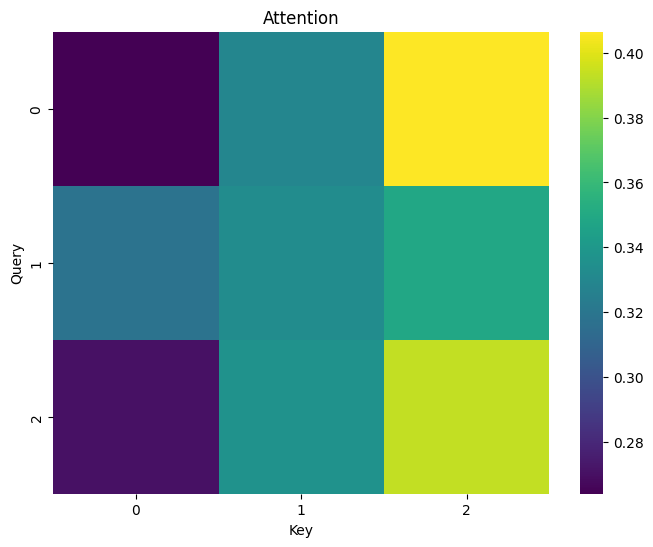

In [102]:
# 创建一些测试数据
# 这里假设每个输入的维度是 d_k = 4，序列长度为 3
batch_size = 2
num_heads = 1
seq_len = 3
d_k = 4

# 生成随机的 query, key, value 张量
query = torch.rand(batch_size, num_heads, seq_len, d_k)
key = torch.rand(batch_size, num_heads, seq_len, d_k)
value = torch.rand(batch_size, num_heads, seq_len, d_k)

# 生成可选的 mask 张量
mask = torch.ones(batch_size, num_heads, seq_len, seq_len)

# 测试 attention 函数
output, attention_weights = attention(query, key, value, mask)

# 输出测试结果
print(attention_weights.shape)
print(output.shape)

show_heatmaps(attention_weights)

In [103]:
# def clones(module, N):
#     return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

# # 假设 MultiHeadedAttention 类已经定义
# class MultiHeadedAttention(nn.Module):
#     def __init__(self, h, d_model, dropout=0.1):
#         super(MultiHeadedAttention, self).__init__()
#         assert d_model % h == 0
        
#         self.d_k = d_model // h
#         self.h = h
#         self.linears = clones(nn.Linear(d_model, d_model), 4)
#         self.attn = None
#         self.dropout = nn.Dropout(p=dropout)
        
#     def forward(self, query, key, value, mask=None):
#         if mask is not None:
#             mask = mask.unsqueeze(1)

#         nbatches = query.size(0)
        
#         # 切分成多头
#         ## value,query,size : (batch_size, seq_len, d_model) 
#         ## l(x): (batch_size, seq_len, d_model) 
#         ## .view(nbatches, -1, self.h, self.d_k) -> (batch_size, seq_len, num_heads, d_k)
#         ## .transpose(1, 2) -> (batch_size, num_heads, seq_len, d_k) 转置操作
        
#         # zip -> (linear0, query) (linear1, key) (linear2, value)
#         # 最后一个linear没有被绑定
        
#         query, key, value = [
#             l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
#             for l, x in zip(self.linears, (query, key, value))
#         ]
        
#         # 求解注意力
#         x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)
        
#         # 此时x:(batch_size, num_heads, seq_len, d_model)
#         # 转置回来 重新变成(batch_size, seq_len, num_heads, d_k)
#         # 修正存储 保证数值一定是连续存储的 .contiguous()
#         # 否则无法使用.view() -> (batch_size, seq_len , d_model)
#         x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)        
        
#         # 使用最后一个linear
#         return self.linears[-1](x)


In [104]:
def clones(module, n):
    # 深拷贝
    return nn.ModuleList([copy.deepcopy(module) for _ in range(n)])

class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        self.h, self.d_k = h, d_model//h
        self.dropout = nn.Dropout(dropout)
        self.attn = None
        self.linears = clones(nn.Linear(d_model, d_model), 4)
    
    def forward(self, query, key, value, mask=None):
        if mask is not None:
            mask = mask.unsqueeze(1)
            
        batch_size = query.size(0)

        # 切分成多头
        ## value,query,size : (batch_size, seq_len, d_model) 
        ## linear(x): (batch_size, seq_len, d_model) 
        ## .view(batche_size, -1, self.h, self.d_k) -> (batch_size, seq_len, num_heads, d_k)
        ## .transpose(1, 2) -> (batch_size, num_heads, seq_len, d_k) 转置操作
        
        # zip -> (linear0, query) (linear1, key) (linear2, value)
        # 最后一个linear没有被绑定
        
        query, key, value = [
            linear(x).view(batch_size, -1, self.h, self.d_k).transpose(1, 2)
            for linear, x in zip(self.linears, (query, key, value))
        ]
        
        # 此时x:(batch_size, num_heads, seq_len, d_model)
        # 转置回来 重新变成(batch_size, seq_len, num_heads, d_k)
        # 修正存储 保证数值一定是连续存储的 .contiguous()
        # 否则无法使用.view() -> (batch_size, seq_len , d_model)
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)
        x = x.transpose(1, 2).contiguous().view(batch_size, -1, self.d_k*self.h)
        return self.linears[-1](x)

In [105]:

# 测试 MultiHeadedAttention
def test_multi_headed_attention_with_mask():
    # 定义一些参数
    batch_size = 2
    seq_len = 5
    d_model = 16
    h = 4
    
    # 随机生成一些输入张量
    query = torch.rand(batch_size, seq_len, d_model)
    key = torch.rand(batch_size, seq_len, d_model)
    value = torch.rand(batch_size, seq_len, d_model)
    
    # 创建一个 mask，假设要忽略序列中的最后一个时间步
    mask = torch.ones(batch_size, num_heads, seq_len)
    mask[:, -1] = 0  # 忽略最后一个时间步

    # 创建 MultiHeadedAttention 实例
    mha = MultiHeadedAttention(h, d_model)
    
    # 前向传播
    output = mha(query, key, value, mask=mask)
    
    # 打印输出的形状
    print("Output shape:", output.shape)
    
    # 检查输出的维度是否符合预期
    assert output.shape == (batch_size, seq_len, d_model), "Output shape mismatch!"
    
    print("Test passed with mask!")

# 运行测试
test_multi_headed_attention_with_mask()


Output shape: torch.Size([2, 5, 16])
Test passed with mask!


In [106]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model) # Dropout不能放在最后
        )
    def forward(self, x):
        return self.ffn(x)
    
temp = PositionwiseFeedForward(512, 2048)
x = torch.rand(5,1000, 512)
x = temp(x)
print(x.shape)


torch.Size([5, 1000, 512])


In [107]:
class LayerNorm(nn.Module):
    def __init__(self, dim, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a = nn.Parameter(torch.ones(dim))
        self.b = nn.Parameter(torch.zeros(dim))
        self.eps = eps
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True) # 求出最后一维的均值
        std = x.std(dim=-1, keepdim=True) # 求出最后一维的方差
        
        # keepdim 把最后一个维度的所有数据替换成一个数字：计算结果
        # 其他维度不变，方便后续的广播
        
        # 防止除以0
        return self.a * (x - mean) / (std + self.eps) + self.b

In [108]:
d_model = 512
layer_norm = LayerNorm(d_model)
batch_size = 2
seq_len = 10
output = layer_norm( torch.randn(batch_size, seq_len, d_model) )
print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([5, 1000, 512])
Output shape: torch.Size([2, 10, 512])


In [109]:
class SublayerConnection(nn.Module):
    def __init__(self, dim, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(dim)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x, sublayer):
        return x + self.dropout(sublayer( self.norm(x) ))
    

In [110]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, self_attention, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attention = self_attention # encoder使用的自注意力机制
        self.feed_forward = feed_forward
        self.sublayer = clones( SublayerConnection(d_model, dropout), 2) # encoder两次残差归一化层
        self.d_model = d_model
        
    def forward(self, x, mask):
        # 通过自注意力机制
        # sublayer.forward传入(x,func)两个参数 第二个参数要求是函数
        # 使用lambda封装 
        # x同时作为query key value
        x = self.sublayer[0](x, lambda x: self.self_attention(x,x,x,mask) )
        
        # 通过Feed-Forward
        return self.sublayer[-1](x, self.feed_forward)
        

In [111]:
class Encoder(nn.Module):

    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N) # layer层重复N次
        self.norm = LayerNorm(layer.d_model)
        
    def forward(self, x, mask):
        # 滚动N遍encoder
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

In [112]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.d_model = d_model 
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(d_model, dropout), 3)
 
    def forward(self, x, memory, src_mask, tgt_mask):
        m = memory # encoder的输出
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask)) # 结合encoder
        return self.sublayer[2](x, self.feed_forward)

In [113]:
class Decoder(nn.Module):
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.d_model)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

In [114]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

In [115]:
class Generator(nn.Module):
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        # 对数 softmax 以防止数值不稳定性
        # 返回概率分布
        return F.log_softmax(self.proj(x), dim=-1)

In [116]:

class EncoderDecoder(nn.Module):

    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed 
        self.tgt_embed = tgt_embed
        self.generator = generator
   
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)
         
    def forward(self, src, tgt, src_mask, tgt_mask):
        return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)
    

In [117]:
def make_model(src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1):
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), 
                             c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab))
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model
tmp_model = make_model(10, 10, 2)

/tmp/ipykernel_3730/2280125763.py:16: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(p)
